# Evaluation - sDCG, Effort vs Effect, sRBP #

### Important notes ###

- paths may have to be adjusted (search for '# path')

## Vorbereitung ##

In [1]:
# imports
from eval_utils import *

In [ ]:
log_root_path = "./sims/output/" # path
#load all logs
log_files = glob.glob(f"{log_root_path}*.log")

sims = set() # simulations
rankings = set() # ranking methods
topics = set() #
strats = set() # query strategies
users = set() 
crits = set() # reformulation criteria

log_cnt = 0

log_df = pd.DataFrame(columns=['Simulation', 'Ranking', 'Strat', 'User', 'Crit', 'Topics'])

for path in log_files:
    res = get_log_props(path, log_root_path)
    if res:
        log_cnt +=1
        sim, ranking, topic, strat, user, crit = res
        topics.add(topic)
        strats.add(strat)
        users.add(user)
        sims.add(sim)
        rankings.add(ranking)
        crits.add(crit)

        row = {'Simulation' : sim, 'Ranking': ranking, 'Strat' : strat,  'User': user, 'Crit': crit, 'Topics' : topic}
        log_df = pd.concat([log_df, pd.DataFrame([row])])

print(f"number of log files: {log_cnt}")
print(f"simulations: {sims}")
print(f"rankings: {rankings}")
print(f"topics: {sorted(topics, key=lambda x: int(x))}")
print(f"strats: {strats}")
print(f"users: {users}")
print(f"crits: {crits}")

print(log_df.groupby(['Simulation', 'Ranking', 'Strat', 'User', 'Crit'])['Topics'].agg(lambda x: len(x)).reset_index().to_string())

# ------------------------------

# evaluation levels
levels = [rankings, strats, users, crits]
levelnames = ['Rankings', 'Query Strategies', 'Users', 'Reformulation Criteria']


# fixed values for other levels (optional; can be more than one), adjustments are possible
c_rankings = {'query_type':['GPT+']}
c_strats = {'user':['perfect']}
c_users = {'query_type':['GPT+'], 'crit':['10rpp'], 'ranking':['bm25']}
c_crits = {'query_type':['D2Q++'], 'user':['perfect'], 'ranking':['bm25'], 'crit':['t50nr', '10rpp', 't100nr', 't150nr']}


fixed = [c_rankings, c_strats, c_users, c_crits]

# Relevance judgements
wapo_qrels = relevance_judgements('./data/wapo/wapo_qrels') # path
nyt_qrels = relevance_judgements('./data/nyt/nyt_qrels') # path
# Evaluation
#querynumber: How many queries per session will be considered in the evaluation
# querynumber = querynumber_min_max_avg(log_files)[2] # 0: minimum number of queries in all log files, 1: maximum number of queries in all log files, 2: average number of queries (rounded) in all log files
# may take some time with a large number of logfiles
querynumber = 100

# different querynumbers for different measures (not necessary for effort/effect)
querynumber_sDCG = querynumber
querynumber_sRBP = querynumber 

# colors for bm25/monoT5 comparison 
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']


## sDCG ##

In [3]:
# sDCG parameters
b_sdcg = 2
bq_sdcg = 4

In [4]:
def dcg(results, topic, qrels):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b_sdcg))

    return _dcg

In [5]:
# sDCG for given evaluation level and simulation with optional fixed values for other evaluation levels
def sDCG_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    sdcg_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any()]
    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    for l in existing_levels:
        for topic in topics_to_analyze:
            sdcg_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    query_logs = {}            
                    query = ''
                    results = []
                
                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')

                            if logs[1] == 'QUERY':
                                if len(query) > 0:
                                    query_logs[query] = results
                                results = []
                                query = ' '.join(logs[4:]).strip('\n')

                            elif logs[1] == 'SNIPPET':
                                results.append('only_snippet') # Added to ensure the alignment of the considered documents, but without the document name since it was not viewed, and therefore, no information was extracted from the document
                            elif logs[1] == 'DOC': 
                                results.pop() # Before Doc, there is always a snippet from the same document, and that's why 'only_snippet' was added. If the document was subsequently considered, it must be deleted          
                                results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))    

                            elif logs[0] == 'INFO': # add last query
                                query_logs[query] = results

                        sdcg = {}
                        _sdcg = 0.0
                        for q, query in enumerate(query_logs.keys()):
                            results = query_logs.get(query)   
                            _sdcg += dcg(results, topic, qrels) / (1 + math.log(q + 1, bq_sdcg))
                            sdcg[q+1] = _sdcg

                        # Carry forward the last value so that it is not filled with 0
                        last_sdcg = sdcg[len(sdcg)]
                        for i in range(len(sdcg)+1,querynumber_sDCG+1):
                            sdcg[i] = last_sdcg

                        sdcg_eval_combi[c] = sdcg
                        c += 1
            sdcg_eval[topic] = pd.DataFrame.from_dict(sdcg_eval_combi)[:querynumber_sDCG].T.mean().to_dict()
        level_eval[l] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber_sDCG].T.mean().to_dict()
        level_eval_all[l] = sdcg_eval.copy()

    print('sDCG Evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " +str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("sDCG "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).plot(xlabel='Queries', ylabel='sDCG', ax = ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_sdcg(existing_levels, evaluation_level, level_eval_all, querynumber_sDCG, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_sdcg(existing_levels, evaluation_level, level_eval_all, querynumber_sDCG, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/sdcg.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()

In [6]:
# sDCG for given evaluation level and simulation with optional fixed values for other evaluation levels
def sDCG_lev_for_comparison(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    sdcg_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any()]
    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    for l in existing_levels:
        for topic in topics_to_analyze:
            sdcg_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    query_logs = {}            
                    query = ''
                    results = []
                
                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')

                            if logs[1] == 'QUERY':
                                if len(query) > 0:
                                    query_logs[query] = results
                                results = []
                                query = ' '.join(logs[4:]).strip('\n')

                            elif logs[1] == 'SNIPPET':
                                results.append('only_snippet') 

                            elif logs[1] == 'DOC':   
                                results.pop() 
                                results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))    

                            elif logs[0] == 'INFO':
                                query_logs[query] = results

                        sdcg = {}
                        _sdcg = 0.0
                        for q, query in enumerate(query_logs.keys()):
                            results = query_logs.get(query)   
                            _sdcg += dcg(results, topic, qrels) / (1 + math.log(q + 1, bq_sdcg))
                            sdcg[q+1] = _sdcg
                            
                        # Carry forward the last value so that it is not filled with 0
                        last_sdcg = sdcg[len(sdcg)]
                        for i in range(len(sdcg)+1,querynumber_sDCG+1):
                            sdcg[i] = last_sdcg

                        sdcg_eval_combi[c] = sdcg
                        c += 1
            sdcg_eval[topic] = pd.DataFrame.from_dict(sdcg_eval_combi)[:querynumber_sDCG].T.mean().to_dict()
        level_eval[l] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber_sDCG].T.mean().to_dict()
        level_eval_all[l] = sdcg_eval.copy()
    
    return level_eval

In [8]:
# Evaluation of all log files from a simulation (provided here); WITHOUT considering different properties, comparability, etc
def sDCG_all(sim, logfiles):
    full_eval = {}
    sdcg_eval = {}
    
    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")

    for f in logfiles:
        log_path = f
            
        query_logs = {}        
        query = ''
        results = []
                        
        with open(log_path, errors='ignore') as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                elif logs[1] == 'SNIPPET':
                                results.append('only_snippet') 

                elif logs[1] == 'DOC':  
                    results.pop() 
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))   

                elif logs[0] == 'INFO':
                    query_logs[query] = results

        sdcg = {}
        _sdcg = 0.0

        topic = log_path.split('-')[2]

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic, qrels) / (1 + math.log(q + 1, bq_sdcg))
            sdcg[q+1] = _sdcg
        # Carry forward the last value so that it is not filled with 0
        last_sdcg = sdcg[len(sdcg)]
        for i in range(len(sdcg)+1,querynumber_sDCG+1):
            sdcg[i] = last_sdcg
            
        sdcg_eval[f] = sdcg
    full_eval[0] = pd.DataFrame.from_dict(sdcg_eval)[:querynumber_sDCG].T.mean().to_dict()

    print('sDCG evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(logfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(logfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("sDCG "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).plot(xlabel='Queries', ylabel='sDCG', legend=False, ax=ax1)
    ax2 = fig.add_subplot(1,3,2)
    eva_df = pd.DataFrame.from_dict(sdcg_eval, orient="index").stack().to_frame()
    eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','query'])
    eva_df = eva_df.rename(columns={0:'gain'})
    eva_df = eva_df[eva_df.apply(lambda row: row['query'] <= querynumber_sDCG, axis=1)]
    sns.lineplot(data = eva_df, x='query',y='gain', ax=ax2)
    ax3 = fig.add_subplot(1,3,3)
    sns.histplot(eva_df['gain'], ax= ax3)

    plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/sdcg.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

## Effort vs. Effect ##

In [15]:
# Effort vs Effect for given evaluation level and simulation with optional fixed values for other evaluation levels
def effeff_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3= False):
    
    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    gain_all = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)
    
    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            
            gain_all_combi = {}

            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    _gain = 0
                    gain = {}  

                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')
                            
                            if len(logs) > 4 and logs[0] == 'ACTION':

                                if logs[1] == 'DOC':
                                    result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                                    if qrels.get((str(topic),result)):
                                        _gain += int(qrels.get((str(topic),result)))
                                gain[int(logs[3])] = _gain

                    gain_all_combi[c] = gain    
                    c += 1
            gain_all[topic] = pd.DataFrame.from_dict(gain_all_combi).sort_index().fillna(method='ffill').T.mean().to_dict() 

        level_eval[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
        level_eval_all[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()
    
    print('Effect vs. Effort evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " + str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("Effort vs Effect "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', ax=ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_effeff(existing_levels, evaluation_level, level_eval_all, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_effeff(existing_levels, evaluation_level, level_eval_all, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/effort_effect.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


In [16]:
# Effort vs Effect for given evaluation level and simulation with optional fixed values for other evaluation levels
def effeff_lev_for_comparison(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3= False):
    
    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    gain_all = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)
    
    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            
            gain_all_combi = {}

            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    _gain = 0
                    gain = {}  

                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')
                            
                            if len(logs) > 4 and logs[0] == 'ACTION':

                                if logs[1] == 'DOC':
                                    result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                                    if qrels.get((str(topic),result)):
                                        _gain += int(qrels.get((str(topic),result)))
                                gain[int(logs[3])] = _gain

                    gain_all_combi[c] = gain    
                    c += 1
            gain_all[topic] = pd.DataFrame.from_dict(gain_all_combi).sort_index().fillna(method='ffill').T.mean().to_dict() 

        level_eval[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
        level_eval_all[l] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()
    return level_eval

In [43]:
# Evaluation of all log files from a simulation (provided here); WITHOUT considering different properties, comparability, etc
def effeff_all(sim, logfiles):
    full_eval = {}
    gain_all = {}
    eval_all = {}

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
    
    for f in logfiles:
        log_path = f
        topic = log_path.split('-')[2]
            
        _gain = 0
        gain = {}
                        
        with open(log_path, errors='ignore') as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'DOC':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')  
                        if qrels.get((topic,result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain

        gain_all[f] = gain
    full_eval[0] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
    eval_all[0] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').to_dict()

    print('Effort vs Effect evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(logfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(logfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("Effort vs Effect "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).sort_index().fillna(method='ffill').plot(xlabel='Effort', ylabel='Effect', legend=False, ax=ax1)
    #leave out for performance reasons

    #ax2 = fig.add_subplot(1,3,2)
    #eva_df = pd.DataFrame.from_dict(eval_all[0], orient="index").stack().to_frame()
    #eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','cost'])
    #eva_df = eva_df.rename(columns={0:'gain'})
    #eva_df = eva_df[eva_df.apply(lambda row: row['cost'] <= 10000, axis=1)]
    #sns.lineplot(data = eva_df, x='cost',y='gain', ax=ax2)
    #ax3 = fig.add_subplot(1,3,3)
    #sns.histplot(eva_df['gain'], ax= ax3)

    #plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/effort_effect.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

## sRBP ##

In [18]:
# Aldo Lipani sRBP (https://github.com/aldolipani/sRBP/blob/master/main.ipynb)

# Discount function
def d_srbp(b, p, m, n):
    def spow(base, exp):
        if base == 0 and exp == 0:
            return 1.0
        else:
            return base**exp
        
    if b == 1.0 and p == 1.0:
        if m == 0:
            return spow(b*p, n)
        else:
            return 0.0
    
    else:
        return spow((p - b*p)/(1.0 - b*p), m)*spow(b*p, n)
# b: balance parameter (balances between reformulating queries and examining more documents)
# p: persistence parameter (persistence of users in continuing search)
# m: reformulation
# n: document rank

def session_based_measure(d, sessions):
    res = 0.0
    for session in sessions:
        n=0 # rank
        m=0 # reformulation
        for event in session:
            if event.startswith('q'):
                m=0
                n=0
            elif event == 'r':
                n=0
                m+=1
            elif event.endswith('-1'):
                res+= d(m, n)
                n+=1
            elif event != 'f':
                n+=1

        res/=len(sessions)

        return res
    
# sRBP for all sessions
def srbp(b, p, sessions):
    return (1-p)*session_based_measure(lambda m, n : d_srbp(b, p, m, n), sessions)
# 1 - p: normalization factor

In [19]:
# b_p_srbp(log_files): determine best b and p for sRBP based on the log data (using all log-files for overall value or a specific part for example for one simulation)
# the code is from Aldo Lipani (https://github.com/aldolipani/sRBP/blob/master/main.ipynb) and only slightly modified to fit the log-file format
# returns best_b, best_p
def b_p_srbp(log_files):

    max_reformulation = 0
    max_rank = 0

    # determine max reformulation and max rank
    for log_file in log_files:
        m = -1 # Use -1 instead of 0 because the value is already incremented in the first query (i.e., the original formulation, not the new formulation); in the original (by Lipani), the first query of a session can be distinguished from the others
        n = 0
        with open(log_file, errors='ignore') as f_in:
            for line in f_in.readlines():
                parts = line.split(' ')
                if parts[1] == 'QUERY':
                    m += 1
                    n = 0
                    if m > max_reformulation:
                        max_reformulation = m
                if parts[1] == 'SNIPPET':
                    n += 1
                    if n > max_rank:
                        max_rank = n

            
    count = [[0] * max_rank for i in range(max_reformulation+1)]
    for log_file in log_files:
        m = -1 # s.o.
        n = 0
        with open(log_file, errors='ignore') as f_in:
            for line in f_in.readlines():
                parts = line.split(' ')
                if parts[1] == 'QUERY':
                    m += 1
                    n = 0
                if parts[1] == 'SNIPPET':
                    count[m][n] += 1
                    n += 1
            
    df = pd.DataFrame(count)
    df = df/df.values.sum()
    gt = df.values
    df.transpose()

    M = gt.shape[0]
    N = gt.shape[1]

    min_err = sys.float_info.max
    res = 100
    best_p = -1
    best_b = -1
    grid = {}

    def tse_srbp(b, p):
        norm = 0.0
        for i in range(M*N):
            norm += d_srbp(b, p, i//N, i%N)
        err = 0.0
        for i in range(M*N):
            err += (gt[i//N, i%N]-d_srbp(b, p, i//N, i%N)/norm)**2
        return err

    t = tqdm(np.linspace(0, 1, res+1), desc = "TSE: {:.4f}".format(min_err))
    for p_i, p in enumerate(t):

        grid[p_i] = []
        for b in np.linspace(0, 1, res+1):
            
            err = tse_srbp(b, p)
            
            grid[p_i].append(err)

            if err < min_err:
                min_err = err
                best_p = p
                best_b = b
                t.set_description("TSE: {:.4f}".format(min_err))

    grid = pd.DataFrame.from_dict(grid)

    srbp_best_b = best_b
    srbp_best_p = best_p

    print("b =", best_b, ", p =", best_p, ", TSE = {:.4f}".format(min_err))
    return best_b, best_p

In [20]:
# sRBP parameters
p_srbp = 0.99 # persistence parameter (probability of continuing the search)
b_srbp = 0.9 # balance parameter (balance between 'considering the next element' and 'reformulating the query.')
#b_srbp, p_srbp = b_p_srbp(log_files) # b und p based on logfiles

In [21]:
# sRBP value for one session (using discount function from Lipani)
def s_rbp(b, p, log_path, topic, qrels):
    res = 0.0
    n = 0
    m = 0
    
    query_rbp = {}

    with open(log_path, errors='ignore') as f_in:

        for line in f_in.readlines():
            logs = line.split(' ')

            if logs[1] == 'QUERY': # new query, increase reformulation count
                query_rbp[m] = (1-p)*res # sRBP after each query
                m += 1
                n = 0
            
            elif logs[1] == 'SNIPPET': # showing new document from the ranking, increase rank count
                n += 1

            elif logs[1] == 'DOC': # add d_srbp value for clicked document to the result          
                if qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n'))):
                    if int(qrels.get((str(topic),logs[5].replace("b'", "").replace("'", "").strip('\n')))) > 0:
                        res += d_srbp(b, p, m, n)

    return (1-p)*res, query_rbp # return sRBP for whole session, list of sRBP values after each query

In [22]:
def sRBP_lev(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    srbp_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            srbp_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1] 

                    # Carry forward the last value so that it is not filled with 0
                    last_srbp = srbp[len(srbp)-1]
                    for i in range(len(srbp),querynumber_sRBP):
                        srbp[i] = last_srbp    

                    srbp_eval_combi[c] = srbp
                    c += 1

            srbp_eval[topic] = pd.DataFrame.from_dict(srbp_eval_combi)[:querynumber_sRBP].T.mean().to_dict()

        level_eval[l] = pd.DataFrame.from_dict(srbp_eval)[:querynumber_sRBP].T.mean().to_dict()
        level_eval_all[l] = srbp_eval.copy()
        
    print('sRBP Evaluation: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " + str(combinations))
    plotcount = np.count_nonzero([plot1, plot2, plot3])
    if plotcount >= 1:
        fig=plt.figure(figsize=(4*plotcount, 4))
        if plot1 == True:
            ax1 = fig.add_subplot(1,plotcount,1)
            ax1.set_title("sRBP "+sim+ " " + evaluation_level)
            pd.DataFrame.from_dict(level_eval).sort_index().fillna(method='ffill').plot(xlabel='Queries', ylabel='sRBP', ax=ax1)
        if plot2 == True:
            position = 2 if plot1 == True else 1
            ax2 = fig.add_subplot(1,plotcount,position)
            lineplot_srbp(existing_levels, evaluation_level, level_eval_all, querynumber_sRBP, ax = ax2)
        if plot3 == True:
            ax3 = fig.add_subplot(1,plotcount,plotcount)
            histplots_srbp(existing_levels, evaluation_level, level_eval_all, querynumber_sRBP, ax = ax3)
        plt.tight_layout(pad=0.5)
        #plt.savefig(f'figures/srbp.{sim}.{evaluation_level.replace(" ","")}.pdf', bbox_inches="tight")
        plt.show()


In [23]:
def sRBP_lev_for_comparison(sim, level, fixed_values = {}, plot1 = True, plot2 = False, plot3 = False):

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
        
    evaluation_level = levelname(level, levels, levelnames)

    level_eval = {}
    srbp_eval = {}

    level_eval_all = {}

    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    existing_levels = [l for l in new_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any() ]
    for l in existing_levels:
            
        for topic in topics_to_analyze:
            srbp_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1] 

                    # Carry forward the last value so that it is not filled with 0
                    last_srbp = srbp[len(srbp)-1]
                    for i in range(len(srbp),querynumber_sRBP):
                        srbp[i] = last_srbp    

                    srbp_eval_combi[c] = srbp
                    c += 1

            srbp_eval[topic] = pd.DataFrame.from_dict(srbp_eval_combi)[:querynumber_sRBP].T.mean().to_dict()

        level_eval[l] = pd.DataFrame.from_dict(srbp_eval)[:querynumber_sRBP].T.mean().to_dict()
        level_eval_all[l] = srbp_eval.copy()
        
    return level_eval

In [118]:
# sRBP value for all provided log files
def sRBP_all(sim, logfiles):

    full_eval = {}
    srbp_eval = {}

    if sim == 'wapo':
        qrels = wapo_qrels
    elif sim == 'nyt':
        qrels = nyt_qrels
    else:
        print("Unknown simulation")
    
    for f in logfiles:
        log_path = f
        
        topic = log_path.split('-')[2]

        srbp = s_rbp(b_srbp, p_srbp, log_path, topic, qrels)[1]
        
        # Carry forward the last value so that it is not filled with 0
        last_srbp = srbp[len(srbp)-1]
        for i in range(len(srbp),querynumber_sRBP):
            srbp[i] = last_srbp 

        srbp_eval[f] = srbp
    
    full_eval[0] = pd.DataFrame.from_dict(srbp_eval)[:querynumber_sRBP].T.mean().to_dict()

    print('sRBP evaluation of all ' + sim + ' files')
    print('number of sessions: ' + str(len(logfiles)))
    print('minimum / maximum / average queries per session: ' + str(querynumber_min_max_avg(logfiles)))
    fig=plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title("sRBP "+sim+ " " + 'all')
    pd.DataFrame.from_dict(full_eval).plot(xlabel='Queries', ylabel='sDCG', legend=False, ax=ax1)
    ax2 = fig.add_subplot(1,3,2)
    eva_df = pd.DataFrame.from_dict(srbp_eval, orient="index").stack().to_frame()
    eva_df = pd.DataFrame(eva_df[0].values.tolist(), index=eva_df.index).reset_index(names=['file','query'])
    eva_df = eva_df.rename(columns={0:'gain'})
    eva_df = eva_df[eva_df.apply(lambda row: row['query'] <= querynumber_sRBP, axis=1)]
    sns.lineplot(data = eva_df, x='query',y='gain', ax=ax2)
    ax3 = fig.add_subplot(1,3,3)
    sns.histplot(eva_df['gain'], ax= ax3)

    plt.tight_layout(pad=0.5)
    #plt.savefig(f'figures/srbp.{sim}.all_logs.pdf', bbox_inches="tight")

    plt.show()

## Complete evaluation ##

In [34]:
# Complete evaluation: All graphs are displayed for each evaluation level and each simulation (at the level-specific and general level)
def full_evaluation():
    for sim in sims:
        print(sim)
        sDCG_all(sim, sim_files(sim,log_files))
        effeff_all(sim, sim_files(sim,log_files))
        sRBP_all(sim, sim_files(sim,log_files))
        for level in levels:
            sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)

# When using (sDCG/effeff/sRBP)_all as done here and simply providing all log files, the result can naturally be challenging to interpret. However, you can filter out the log files in advance (e.g., using filter_logfiles) that you wish to pass, and then evaluate them selectively.



In [122]:
# Complete evaluation for one simulation
def sim_evaluation(sim):
    print(sim)
    for level in levels:
            #sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            #effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            #sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = True, plot3 = True)
            sDCG_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = False, plot3 = False)
            effeff_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = False, plot3 = False)
            sRBP_lev(sim, level, fixed[levels.index(level)], plot1 = True, plot2 = False, plot3 = False)
    sDCG_all(sim, sim_files(sim,log_files))
    effeff_all(sim, sim_files(sim,log_files))
    sRBP_all(sim, sim_files(sim,log_files))

## Snippets per Query ##

In [133]:
# number of snippets seen per query with different stopping criteria
def snippets_query(sim, level, fixed_values = {}):
        
    evaluation_level = levelname(level,levels,levelnames)

    level_eval = {}
    snippets_eval = {}


    fixed_l = levels.copy()
    level_index = levels.index(level)

    if 'ranking' in fixed_values.keys():
        fixed_l[0] = fixed_values['ranking']
    if 'query_type' in fixed_values.keys():
        fixed_l[1] = fixed_values['query_type']
    if 'user' in fixed_values.keys():
        fixed_l[2] = fixed_values['user']
    if 'crit' in fixed_values.keys():
        fixed_l[3] = fixed_values['crit']

    new_l = fixed_l.copy()

    existing_levels = [l for l in fixed_l[level_index] if ((log_df['Simulation'] == sim) & (log_df.iloc[:,level_index+1] == l)).any()]
    combinations = fixed_combinations(fixed_l, level_index, sim, new_l, log_df)
    topics_to_analyze = available_topics_combinations(log_df, sim, combinations)

    for l in existing_levels:
        for topic in topics_to_analyze:
            snippets_eval_combi = {}
            
            c = 0
            for combination in combinations:
                if combination[level_index] == l:
                    ranking = combination[0]
                    query_type = combination[1]
                    user = combination[2]
                    crit = combination[3]

                    query_logs = {}           
                    query = 0
                    results = 0
                
                    log_path = log_root_path + sim + "-" + ranking + "-" + str(topic) + "-" + query_type + "-" + user + "-" + crit + ".log"
                    with open(log_path, errors='ignore') as f_in:

                        for line in f_in.readlines():
                            logs = line.split(' ')

                            if logs[1] == 'QUERY':
                                if query > 0:
                                    query_logs[query] = results
                                results = 0
                                query += 1
                                
                            if logs[1] == 'SNIPPET':
                                results += 1   

                            if logs[0] == 'INFO':
                                query_logs[query] = results

                        snippets_eval_combi[c] = query_logs
                        c += 1
            snippets_eval[topic] = pd.DataFrame.from_dict(snippets_eval_combi)[:querynumber].T.mean().to_dict()
        level_eval[l] = pd.DataFrame.from_dict(snippets_eval)[:querynumber_sDCG].T.mean().to_dict()

    print('Snippets per query: ' + sim + " " + evaluation_level)
    print("Combinations used in this evaluation: " +str(combinations))
    fig=plt.figure(figsize=(4, 4))
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title("Snippets per query "+sim+ " " + evaluation_level)
    pd.DataFrame.from_dict(level_eval).plot(xlabel='Queries', ylabel='Snippets', ax = ax1)
    plt.show()

## Comparing two plots ##

In [31]:
def compare_two_plots_sDCG(p1, p2):
    for i, key in enumerate(p1.keys()):
        plt.plot(np.array(list((p1[key].values()))),label=key, color=colors[i])
        plt.plot(np.array(list((p2[key].values()))),linestyle='--', color=colors[i])
    plt.legend()
    plt.xlabel('Queries')
    plt.ylabel('sDCG')
    plt.show()

def compare_two_plots_sRBP(p1, p2):
    for i, key in enumerate(p1.keys()):
        plt.plot(np.array(list((p1[key].values()))),label=key, color=colors[i])
        plt.plot(np.array(list((p2[key].values()))),linestyle='--', color=colors[i])
    plt.legend()
    plt.xlabel('Queries')
    plt.ylabel('sRBP')
    plt.show()

def compare_two_plots_effeff(p1, p2):
    df1 = pd.DataFrame.from_dict(p1).sort_index().fillna(method='ffill')
    df2 = pd.DataFrame.from_dict(p2).sort_index().fillna(method='ffill')
    for i, key in enumerate(p1.keys()):
        plt.plot(df1[key],label=key, color=colors[i])
        plt.plot(df2[key],linestyle='--', color=colors[i])
    plt.legend()
    plt.xlabel('Effort')
    plt.ylabel('Effect')
    plt.show()


## Example usage ##

sDCG Evaluation: wapo Users
Combinations used in this evaluation: [['bm25', 'GPT+', 'navigational', '10rpp'], ['bm25', 'GPT+', 'almostrandom', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp'], ['bm25', 'GPT+', 'informational', '10rpp']]


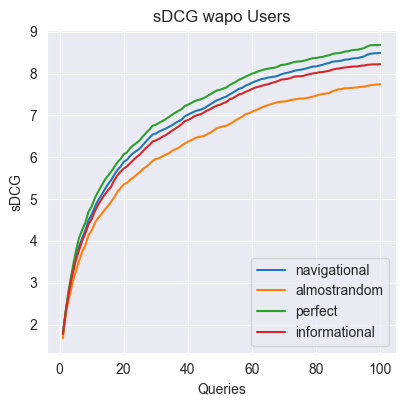

Effect vs. Effort evaluation: nyt Query Strategies
Combinations used in this evaluation: [['bm25', 'D2Q+', 'perfect', '10rpp'], ['bm25', 'D2Q++', 'perfect', '10rpp'], ['bm25', 'GPT', 'perfect', '10rpp'], ['bm25', 'GPT+', 'perfect', '10rpp'], ['bm25', 'D2Q', 'perfect', '10rpp']]


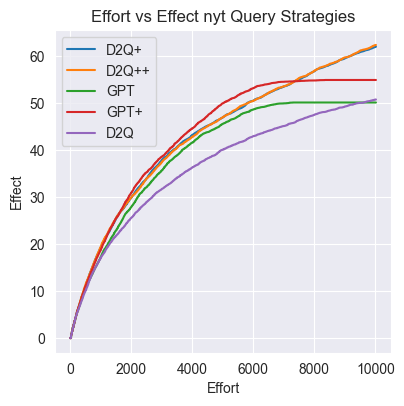

sRBP Evaluation: wapo Reformulation Criteria
Combinations used in this evaluation: [['bm25', 'D2Q++', 'perfect', 't50nr'], ['bm25', 'D2Q++', 'perfect', '10rpp'], ['bm25', 'D2Q++', 'perfect', 't100nr'], ['bm25', 'D2Q++', 'perfect', 't150nr']]


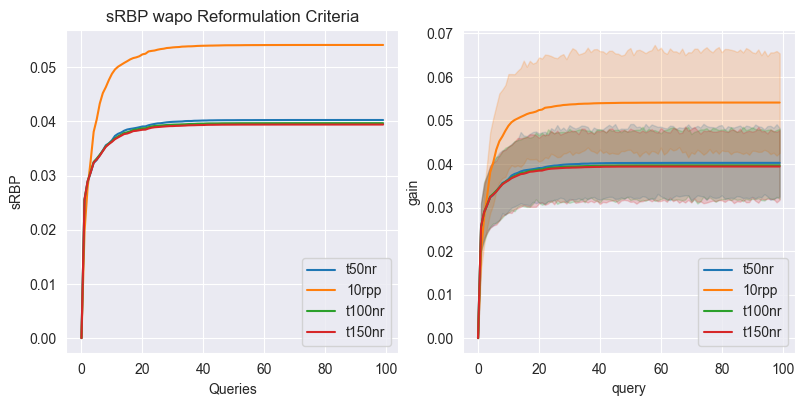

In [125]:
# examples
sDCG_lev('wapo', users, c_users, plot1=True, plot2=False, plot3=False)
effeff_lev('nyt', strats, c_strats, plot1=True, plot2=False, plot3=False)
sRBP_lev('wapo', crits, c_crits, plot1=True, plot2=True, plot3=False)
#effeff_all('wapo', sim_files('wapo', log_files))
#full_evaluation()
#sim_evaluation('wapo')

Snippets per query: wapo Reformulation Criteria
Combinations used in this evaluation: [['bm25', 'D2Q++', 'perfect', 't50nr'], ['bm25', 'D2Q++', 'perfect', '10rpp'], ['bm25', 'D2Q++', 'perfect', 't100nr'], ['bm25', 'D2Q++', 'perfect', 't150nr']]


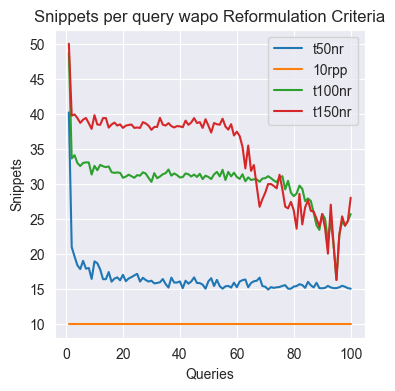

In [138]:
snippets_query('wapo',crits,c_crits)

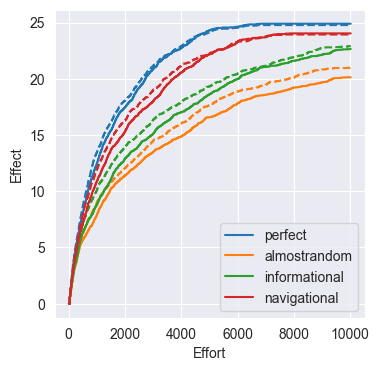

In [32]:
#p1 = sDCG_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['bm25']},plot1=False)
#p2 = sDCG_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['monoT5']},plot1=False)

#p1 = sDCG_lev_for_comparison('wapo',crits,{'query_type':['GPT'], 'crit':['10rpp','t50nr'], 'user': ['informational'], 'ranking':['bm25']},plot1=False)
#p2 = sDCG_lev_for_comparison('wapo',crits,{'query_type':['GPT'], 'crit':['10rpp','t50nr'], 'user': ['informational'], 'ranking':['monoT5']},plot1=False)

#p1 = sRBP_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['bm25']},plot1=False)
#p2 = sRBP_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['monoT5']},plot1=False)

p1 = effeff_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['bm25']},plot1=False)
p2 = effeff_lev_for_comparison('wapo',users,{'query_type':['GPT'], 'crit':['10rpp'], 'ranking':['monoT5']},plot1=False)

compare_two_plots_effeff(p1,p2)
